# Vibe Matcher — Notebook

## 1. Overview

This notebook demonstrates a compact prototype of **Vibe Matcher** — a lightweight recommendation system that maps a user-provided *vibe query* (e.g., `"energetic urban chic"`) to the **top-3 matching fashion products** from a small mock catalog.  

The pipeline uses **SentenceTransformer embeddings** (`all-MiniLM-L6-v2`), **cosine similarity** for ranking, and simple evaluation metrics such as **average similarity** and **latency**.

---

###  Goals

- **Clean, reproducible code** split between `src/` modules and this notebook.  
- **Fully local / Colab-friendly**, runs without OpenAI billing (uses `sentence-transformers`).  
- **Generates interpretable outputs** — ranked products, similarity scores, and visual plots that are easy to inspect and export.

---

###  Deliverables

-  This notebook (**Colab/GitHub link**)  
-  `src/` module files (already included in the repository)  
-  `data/` directory containing:  
  - `fashion_data.csv`  
  - Cached `embeddings_cache.json`

---


### Why AI at Nexora?

AI at Nexora represents the bridge between creativity and intelligence — the ability to turn subjective human feelings like a “vibe” into real, data-driven personalization. It empowers users to discover products that reflect their mood, event, or aesthetic instead of relying on rigid categories. Through this **Vibe Matcher** prototype, I’ve explored how lightweight embeddings and vector similarity can create scalable, interpretable, and emotionally aware recommendations. With strong hands-on experience in this segment — having worked with clients on a **Fashion Classifier** project — I’m confident in applying these techniques to Nexora’s vision of building human-centered, delight-first AI experiences.


In [1]:
# Installing the requirement file
!pip install -q -r requirements.txt


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Notebook: imports
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import sys
sys.path.append("./src") # adjust if necessary

from data_prep import create_mock_data, save_dataframe_to_csv, load_dataframe_from_csv
from embedder import embed_dataframe, get_embedding
from matcher import vibe_matcher, pretty_print_results
from evaluator import evaluate_queries, plot_latency, plot_similarity

# Paths used by this notebook
ROOT = Path(".")
DATA_DIR = ROOT / "data"
ASSETS_DIR = ROOT / "assets"
ASSETS_DIR.mkdir(exist_ok=True)


# Silence matplotlib interactive warnings in some environments
%matplotlib inline

c:\Users\LENOVO\anaconda3\envs\finops\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading local embedding model: all-MiniLM-L6-v2 ...
Model loaded successfully.


In [4]:
# Create or load mock data
try:
    df = load_dataframe_from_csv(DATA_DIR / "fashion_data.csv")
    print("Loaded existing data from data/fashion_data.csv")
except Exception:
    df = create_mock_data()
    save_dataframe_to_csv(df)
    print("Created and saved mock dataset to data/fashion_data.csv")

# Show the dataset
df

Loaded existing data from data/fashion_data.csv


,name,desc,vibe
0,Boho Dress,"Flowy, earthy tones perfect for outdoor festiv...","[boho, free-spirited]"
1,Streetwear Hoodie,Bold colors and oversized fit for an energetic...,"[urban, energetic]"
2,Minimalist White Shirt,"Clean, crisp lines and lightweight fabric for ...","[minimalist, chic]"
3,Cozy Knit Sweater,Soft wool texture to keep you warm—perfect for...,"[cozy, casual]"
4,Elegant Black Blazer,Sharp tailoring and subtle sheen for formal ev...,"[formal, elegant]"
5,Sporty Tracksuit,"Lightweight, breathable fabric with athletic c...","[sporty, casual]"
6,Retro Floral Top,Colorful floral prints with a vintage silhouet...,"[retro, playful]"
7,Denim Jacket,Classic blue denim with a rugged feel for a ti...,"[casual, vintage]"
8,Summer Linen Pants,"Breathable, lightweight linen for cool comfort...","[summer, minimalist]"
9,Glam Sequin Dress,Sparkly sequins and sleek fit for parties and ...,"[glam, evening]"


In [6]:
if "embedding" not in df.columns or df["embedding"].isnull().any():
    print("Embedding descriptions (this may take a few seconds on first run)...")
    df = embed_dataframe(df, text_column="desc", embed_column="embedding")
    # Save a CSV and a pickle for quicker reload
    df.to_pickle(DATA_DIR / "fashion_embeddings.pkl")
    print("Embeddings generated and cached.")   
else:
    print("Embeddings already present.")


# Quick check: embedding dimension
print("Embedding dim:", len(df.loc[0, "embedding"]))

Embedding descriptions (this may take a few seconds on first run)...
Embeddings generated and cached.
Embedding dim: 384


In [7]:
# Helper wrapper: take text query, return top-N matches
def match_query_text(query: str, top_n: int = 3):
    query_emb = get_embedding(query)
    results = vibe_matcher(query_emb, df, top_n=top_n)
    return results


# Demo queries
queries = [
"energetic urban chic",
"warm cozy winter look",
"sparkly evening glam",
]


for q in queries:
    print(f"\nQuery → {q}")
    res = match_query_text(q, top_n=3)
    pretty_print_results(res)


Query → energetic urban chic
Product: Streetwear Hoodie
Vibe: urban, energetic
Score: 0.369
Desc: Bold colors and oversized fit for an energetic city vibe and skate culture.
------------------------------------------------------------
Product: Boho Dress
Vibe: boho, free-spirited
Score: 0.327
Desc: Flowy, earthy tones perfect for outdoor festivals and carefree days.
------------------------------------------------------------
Product: Sporty Tracksuit
Vibe: sporty, casual
Score: 0.238
Desc: Lightweight, breathable fabric with athletic cut for active lifestyles.
------------------------------------------------------------

Query → warm cozy winter look
Product: Cozy Knit Sweater
Vibe: cozy, casual
Score: 0.521
Desc: Soft wool texture to keep you warm—perfect for relaxed winter evenings.
------------------------------------------------------------
Product: Minimalist White Shirt
Vibe: minimalist, chic
Score: 0.474
Desc: Clean, crisp lines and lightweight fabric for a modern, simple look


Query: energetic urban chic
Average score: 0.311 | Latency: 0.01s

Query: warm cozy winter look
Average score: 0.486 | Latency: 0.00s

Query: elegant night out
Average score: 0.436 | Latency: 0.03s


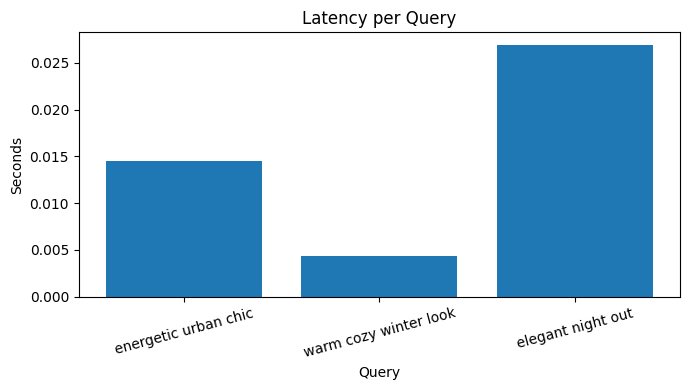

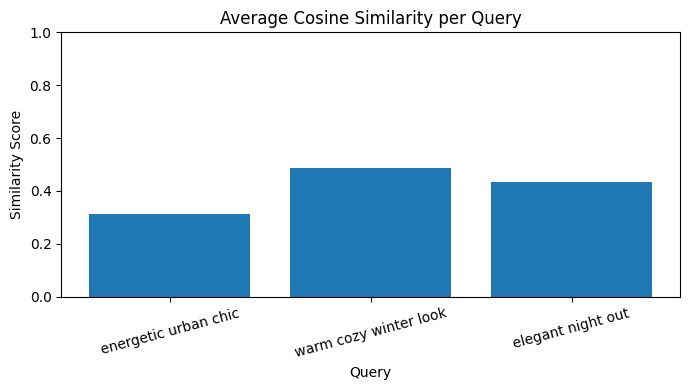

<Figure size 640x480 with 0 Axes>

In [8]:
# Define test queries (you can change these)
test_queries = [
"energetic urban chic",
"warm cozy winter look",
"elegant night out",
]


avg_scores, latencies = evaluate_queries(
test_queries,
embed_fn=get_embedding,
match_fn=vibe_matcher,
df=df,
top_n=3,
)


# Save plots and show
plot_latency(test_queries, latencies)
plot_similarity(test_queries, avg_scores)


# Optionally save the latency plot file
plt.savefig(ASSETS_DIR / "latency_plot.png")

In [11]:
# Simple threshold-based fallback
THRESHOLD = 0.30


def match_with_fallback(query: str, top_n: int = 3, threshold: float = THRESHOLD):
    res = match_query_text(query, top_n=top_n)
    if res['score'].max() < threshold:
        print("No strong match found (all scores < {:.2f}). Consider broadening the vibe.".format(threshold))
        return res
    return res


# Example edge-case query
print("Edge-case query: 'alien spaceship formal' -> expected poor match")
print(match_with_fallback("alien spaceship formal", top_n=3))

Edge-case query: 'alien spaceship formal' -> expected poor match
No strong match found (all scores < 0.30). Consider broadening the vibe.
                     name                                               desc  \
9       Glam Sequin Dress  Sparkly sequins and sleek fit for parties and ...   
2  Minimalist White Shirt  Clean, crisp lines and lightweight fabric for ...   
4    Elegant Black Blazer  Sharp tailoring and subtle sheen for formal ev...   

                 vibe     score  
9     [glam, evening]  0.237600  
2  [minimalist, chic]  0.219631  
4   [formal, elegant]  0.206636  
